# Problema de transporte - Transbordo
--------
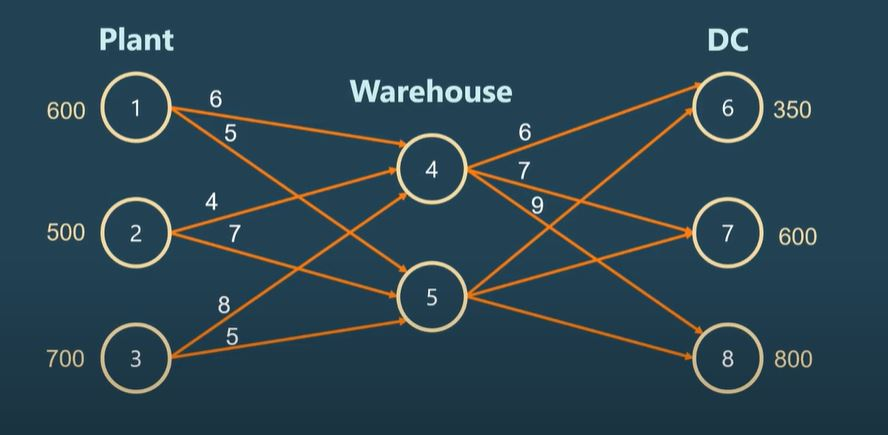

#### ➤ Parâmetros
➔ $F$ : Conjunto das fábricas \\
➔ $D$ : Conjunto de depósitos \\
➔ $L$ : Conjunto de lojas \\
➔ $O_f$ : Produção da fábrica $f$ \\
➔ $D_l$ : Demanda da loja $l$ \\
➔ $c_{ij}$ : custo de transporte de $i$ para $j$, t.q, $ ~~ i,j \in F \cup D \cup L, i \neq j$  \\

#### ➤ Modelagem

➔ **Variáveis de decisão**

$\displaystyle x_{ij} : $ Qtd. de material transportado local $i$ para o local $j$

.

.


➔ **Função objetivo** Minimizar o custo total do transporte

$\displaystyle \min \sum_{i \in F \cup D} \sum_{j \in D \cup L} c_{ij} \cdot x_{ij} $

.

.


➔ **Restrições**


1) A quantidade que sai de cada fábrica deve ser no máximo a quantidade produzida: \\

$\displaystyle \sum_{j \in D} x_{fj} \leq O_f, ~~ \forall f \in F$


2) A quantidade chega em cada loja deve ser no máxima a quantidade demandada: \\

$\displaystyle \sum_{i \in D} x_{il} = D_l, ~~ \forall l \in L$


2) Tudo que entra no depósito deve sair na mesma quantidade:

$\displaystyle \sum_{i \in F} x_{id} = \sum_{i \in L} x_{di}, ~~ \forall d \in D$

## 2) Leitura dos dados

In [ ]:
import pandas as pd

In [ ]:
df_custo_fab_dep = pd.read_excel("dados_problema_transporte.xlsx", sheet_name = "custo_fab_dep")
df_custo_fab_dep.name = "df_custo_fab_dep"
df_custo_fab_dep.head()

In [ ]:
df_custo_dep_lj = pd.read_excel("dados_problema_transporte.xlsx", sheet_name = "custo_dep_lj")
df_custo_dep_lj.name = "df_custo_dep_lj"
df_custo_dep_lj.head()

2.1) Tratamento dos dados

In [ ]:
# Quais os tipos dos dados
data_frames = [df_custo_fab_dep, df_custo_dep_lj ]
for df in data_frames:
  print(">>>>>", df.name)

  display(df.info())

In [ ]:
# Limpando o dataframe

#1. removendo as colunas cujo todos os valores sejam vazios
df_custo_fab_dep = df_custo_fab_dep.dropna(axis=1, how='all')

#2. Removendo uma coluna em que ocorreu um erro de digitação
df_custo_fab_dep = df_custo_fab_dep.drop("Unnamed: 6", axis=1, errors='ignore')

#3. Remover as linhas cujo todos os valores sejam nulos
df_custo_fab_dep = df_custo_fab_dep.dropna(axis=0, how='all')

df_custo_fab_dep.info()

## 3) Extração dos parâmetros para o modelo

In [ ]:
# Conjunto de depósitos

set_D_df_1 = set(df_custo_dep_lj['Depósitos'].unique())
set_D_df_2 = set(df_custo_fab_dep['Depósitos'].unique())

set_D = (set_D_df_1).union(set_D_df_2)

#Existe algum deposito que esteja em uma unica base?
print("df_custo_dep_lj",  set_D - set_D_df_1)
print("df_custo_fab_dep",  set_D - set_D_df_2)
print("D",  set_D)

In [ ]:
# Conjunto de Fábricas
set_F = df_custo_fab_dep['Fábricas'].unique().tolist()
set_F

In [ ]:
# Conjunto de Lojas
set_L =  df_custo_dep_lj['pontos_de_venda'].unique().tolist()
set_L

In [ ]:
# Pares (i,j) da rede

# Pares fábrica - depósito
par_fab_dep = df_custo_fab_dep[['Fábricas', 'Depósitos']].to_records(index=False).tolist()

# Pares fábrica - depósito
par_dep_lj = df_custo_dep_lj[['Depósitos', 'pontos_de_venda']].to_records(index=False).tolist()

par_ij = par_fab_dep + par_dep_lj
par_ij

In [ ]:
# custo de transporte
custo_fab_dep = df_custo_fab_dep.set_index(['Fábricas','Depósitos'])['Custo_tranposte_fab_dep'].to_dict()
custo_fab_dep


custo_dep_lj = df_custo_dep_lj.set_index(['Depósitos','pontos_de_venda'])['custo_transporte_dep_lj'].to_dict()
custo_dep_lj

custo_ij = custo_fab_dep | custo_dep_lj
custo_ij

In [ ]:
# oferta por Fabrica
oferta_fab = df_custo_fab_dep.set_index("Fábricas")['Capacidade_Produtiva'].to_dict()
oferta_fab

In [ ]:
# Demanda por loja
demanda_loj = df_custo_dep_lj.set_index("pontos_de_venda")['Demanda'].to_dict()
demanda_loj

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Lista de tuplas
lista_de_tuplas = par_ij

# Criar um grafo direcionado
G = nx.DiGraph()

# Adicionar as arestas ao grafo
G.add_edges_from(lista_de_tuplas)

# Definir manualmente as posições dos nós em três colunas
pos = {'FAB_1': (0, 2), 'FAB_2': (0, 4), 'FAB_3': (0, 6), 'FAB_4': (0, 8),
       'DEP_1': (1, 4), 'DEP_2': (1, 6),
       'LJ_1': (3, 1), 'LJ_2': (3, 2), 'LJ_3': (3, 3),
       'LJ_4': (3, 4), 'LJ_5': (3, 5), 'LJ_6': (3, 6),
       'LJ_7': (3, 7), 'LJ_8': (3, 8)}

# Plotar o grafo
nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=8, font_weight='bold', arrowsize=10)
plt.title('Grafo da Rede')
plt.show()


## 4) Modelagem e Solução

In [ ]:
! pip install ortools


In [ ]:
from ortools.linear_solver import pywraplp

In [ ]:
# Definindo o solver e criando uma instancia para o modelo
solver_name = "GLOP"
model = pywraplp.Solver.CreateSolver(solver_name)

##### 4.1) Variáveis de decisão

In [ ]:
vars = dict()
vars['x'] = {
    (i,j) :  model.NumVar(lb = 0, ub = model.infinity(), name = f"x[{(i,j)}]")
    for i,j in par_ij
}

##### 4.2) Função Objetivo

In [ ]:
sum_obj = sum(
    vars['x'][(i,j)] * custo_ij[(i,j)]
    for i,j in par_ij
)

model.Minimize(sum_obj)

##### 4.1) Restrições

In [ ]:
# 1) A quantidade que sai de cada fábrica deve ser no máximo a quantidade produzida:
for fab in set_F:
  sum_tudo_que_sai = sum(
      vars['x'][(fab,dep)]
      for dep in set_D
  )

  model.Add(
      sum_tudo_que_sai <= oferta_fab[fab]
  )


In [ ]:
# 2) A quantidade que chega em uma loja deve ser no máximo a quantidade demandada:
for loj in set_L:
  sum_tudo_que_chega = sum(
      vars['x'][(dep,loj)]
      for dep in set_D
  )

  model.Add(
      sum_tudo_que_chega == demanda_loj[loj]
  )

In [ ]:
# 3) Tudo que entra em um depósito deve ser igual a tudo o que sai
for dep in set_D:
  sum_tudo_que_entra = sum(
      vars['x'][(fab,dep)]
      for fab in set_F
  )

  sum_tudo_que_sai = sum(
      vars['x'][(dep,loj)]
      for loj in set_L
  )

  model.Add(
      sum_tudo_que_entra == sum_tudo_que_sai
  )


In [ ]:
print(f"Solving with {model.SolverVersion()}")
model.EnableOutput()
status = model.Solve()

# Imprimir log de solver
print('\nLog de solver:')
print(model.ExportModelAsLpFormat(False).replace('\\', ''))

status_dict = {
            pywraplp.Solver.OPTIMAL: 'OPTIMAL',
            pywraplp.Solver.FEASIBLE: 'FEASIBLE',
            pywraplp.Solver.INFEASIBLE: 'INFEASIBLE',
            pywraplp.Solver.UNBOUNDED: 'UNBOUNDED',
            pywraplp.Solver.ABNORMAL: 'ABNORMAL',
            pywraplp.Solver.NOT_SOLVED: 'NOT_SOLVED'
        }

status_dict[status]

In [ ]:
if status == pywraplp.Solver.OPTIMAL:
    print(f"Solution: {status_dict[status]}")
    print(f"Objective value = {model.Objective().Value():0.1f}")

else:
    print("The problem does not have an optimal solution.")

In [ ]:
solution_x = dict()

for i,j in par_ij:
    solution_x[(i,j)] = vars['x'][(i,j)].solution_value()
solution_x

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Definindo os dados do grafo
edges = solution_x

# Criando um grafo direcionado
G = nx.DiGraph()

# Adicionando as arestas com os respectivos pesos
for edge, weight in edges.items():
    G.add_edge(edge[0], edge[1], weight=int(weight))

# Definindo a posição dos nós no gráfico
pos = {'FAB_1': (0, 2), 'FAB_2': (0, 4), 'FAB_3': (0, 6), 'FAB_4': (0, 8),
       'DEP_1': (6, 4), 'DEP_2': (6, 6),
       'LJ_1': (12, 1), 'LJ_2': (12, 2), 'LJ_3': (12 ,3),
       'LJ_4': (12, 4), 'LJ_5': (12, 5), 'LJ_6': (12 ,6),
       'LJ_7': (12, 7), 'LJ_8': (12, 8)}

# Desenhando os nós
nx.draw_networkx_nodes(G, pos, node_size=1000)

# Desenhando as arestas
nx.draw_networkx_edges(G, pos, width=1)

# Adicionando os rótulos das arestas com os pesos
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

# Adicionando os rótulos dos nós
nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

# Exibindo o gráfico
plt.axis('off')
plt.title('Grafo da Rede - Solução')
plt.show()


In [ ]:
for loj in set_L:
  soma = sum(
      value
      for key, value in solution_x.items()
      if key[-1] == loj
  )
  print(f"Demanda da loja {loj} : {demanda_loj[loj]}  - Decisão: {soma}")

In [ ]:
for fab in set_F:
  soma = sum(
      value
      for key, value in solution_x.items()
      if key[0] == fab
  )
  print(f"Oferta da fábrica {loj} : {oferta_fab[fab]}  - Decisão: {soma}")